In [11]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter

Replace all symboles as text

In [7]:
def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [8]:
def get_batches(int_text, batch_size, seq_length):
    """
    Return batches of input and target
    :param int_text: Text with the words replaced by their ids
    :param batch_size: The size of batch
    :param seq_length: The length of sequence
    :return: A list where each item is a tuple of (batch of input, batch of target).
    """
    n_batches = int(len(int_text) / (batch_size * seq_length))

    # Drop the last few characters to make only full batches
    xdata = np.array(int_text[: n_batches * batch_size * seq_length])
    ydata = np.array(int_text[1: n_batches * batch_size * seq_length + 1])

    x_batches = np.split(xdata.reshape(batch_size, -1), n_batches, 1)
    y_batches = np.split(ydata.reshape(batch_size, -1), n_batches, 1)

    return list(zip(x_batches, y_batches))


def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [9]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [12]:
words = preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [13]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


Creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [15]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. <br>
If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

Drop the words that are more frequent

*Threshold(t)* value is actually a **hyper parameter to tune the model** to take care of noise.

Noise means the words, "the", "of" etc.. those do not provide much of a context for nearby words. These need to be removed for a noise-less model. Again, these words are randomly present in the data and therefore a stochastic way of handling these noise in given by Mikolov.

The formula is given in the notebook where a threshold and a dropout is used to randomly remove the words.

A very simple answer is "random numbers and threshold values are used to remove useless words randomly paced in the input data"

[Reason for threshold value](https://arxiv.org/pdf/1402.3722.pdf)



**Reason for Random Values** <br>
There is a possibility of using fixed values like 0.5, 0.7 etc. But if you do that you are training using the same words for the complete training. But choosing the keep probability as random, we are even randomizing the example used for training. So, the network while training sees different inputs and gets trained based on those inputs. This can be though as being useful to make variation in the dataset even though you are having only small fixed size dataset.

I'm using random.random() there to make the dropping process probabilistic. For each word in the dataset, there is some probability it will be dropped. This is a binary choice, whenever you see a word, you either drop it or you don't, according to `p_drop[word]`. To actually make that choice, and to make it probabilistic, you need to compare it to a random number. random.random() generates a random number between 0 and 1.

In this case, p_drop is the probability to drop a word, and if `p_drop[word] < random.random()` means to keep a word if the probability to drop that word is less than the random number. If `p_drop[word] == 0.9`, then there is a 10% chance that `p_drop[word] < random.random()` is True, then there is a 10% that the word will be kept.

Basically, p_drop is the probability that the word will be dropped, you still have to make the decision to drop it or not. And it needs to be done probabilistically, which is why I use a random number.


you'll see that this number is randomly chosen from a **uniform probability distribution**. So any number from 0 to 1 is equally likely to be chosen.

Imagine you were to repeatedly draw a number from this uniform distribution a large amount of times, say 1 million. Then choose some cut-off point, say 0.75. If the number is below 0.75, then you keep it. Because it's a uniform distribution, you will get about 75% of your numbers below 0.75, and 25% of them above. So the random draw from a uniform distribution realizes the probability to keep or discard a number based upon the threshold that you set.

In [24]:
import random
threshold = 1e-5

# Each word count
word_counts = Counter(int_words)

# Total number of words in text(Not unique)
total_count = len(int_words)

# Word frequncy
freqs = {word:count/ total_count for word, count in word_counts.items()}

# Calculate the Drop Probability drop for each word
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}

# Pick the words which are more than expected probability
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 


We are going to take one word and then we are going to use the words that are around that word in the text as _target_. So to se as the context around whatever input word we have. 


So basically for everyword we're going to grap a window of words around it and window's going to have some _size C_. But what _Mikolov_ has done is, He choosed random range window. Because the distanct words are usually less related to whatever input word you have, So basically you just wnat to kind of de-emphasize words that are further away as compared to words that are closer.


From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 


"Since the **more distant words** are usually **less related to the current word** than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... <br>
**Choose random range...**<br>
If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from pass(words before specific word) and $R$ words from the future(words after specific word) of the current word as correct labels."


Function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [40]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''

    # Create a random value with range of window_size
    R = np.random.randint(1, window_size)

    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R

    target_words = set(words[start:idx] + words[idx + 1:stop + 1])

    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [41]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.


TensorFlow uses a dataflow **graph to represent your computation** in terms of the dependencies between individual operations. This leads to a low-level programming model in which you first define the dataflow graph, then create a TensorFlow **Session to run parts of the graph** across a set of local and remote devices.

In [42]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [43]:
n_vocab = len(int_to_vocab)
n_embedding = 200  # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs) 

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [44]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(
        tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))

    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed,
                                      n_sampled, n_vocab)

    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [45]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [46]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [47]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6624 0.3102 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.5947 0.3023 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.4980 0.3067 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5886 0.3033 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5068 0.3048 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5328 0.3033 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5531 0.3038 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5724 0.3017 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4799 0.3015 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4491 0.3026 sec/batch
Nearest to its: reared, sandbox, anisotropy, external, senators, awg, royalists, starry,
Nearest to i: rarity, published, keegan, centers, shone, studi, makes, drying,
Nearest to system: northward, esas, dyad, cellars, republic, pontic, virgin, oceanographer,
Nearest to however: shedding, aam, heat

Restore the trained network if you need to:

In [48]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [50]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

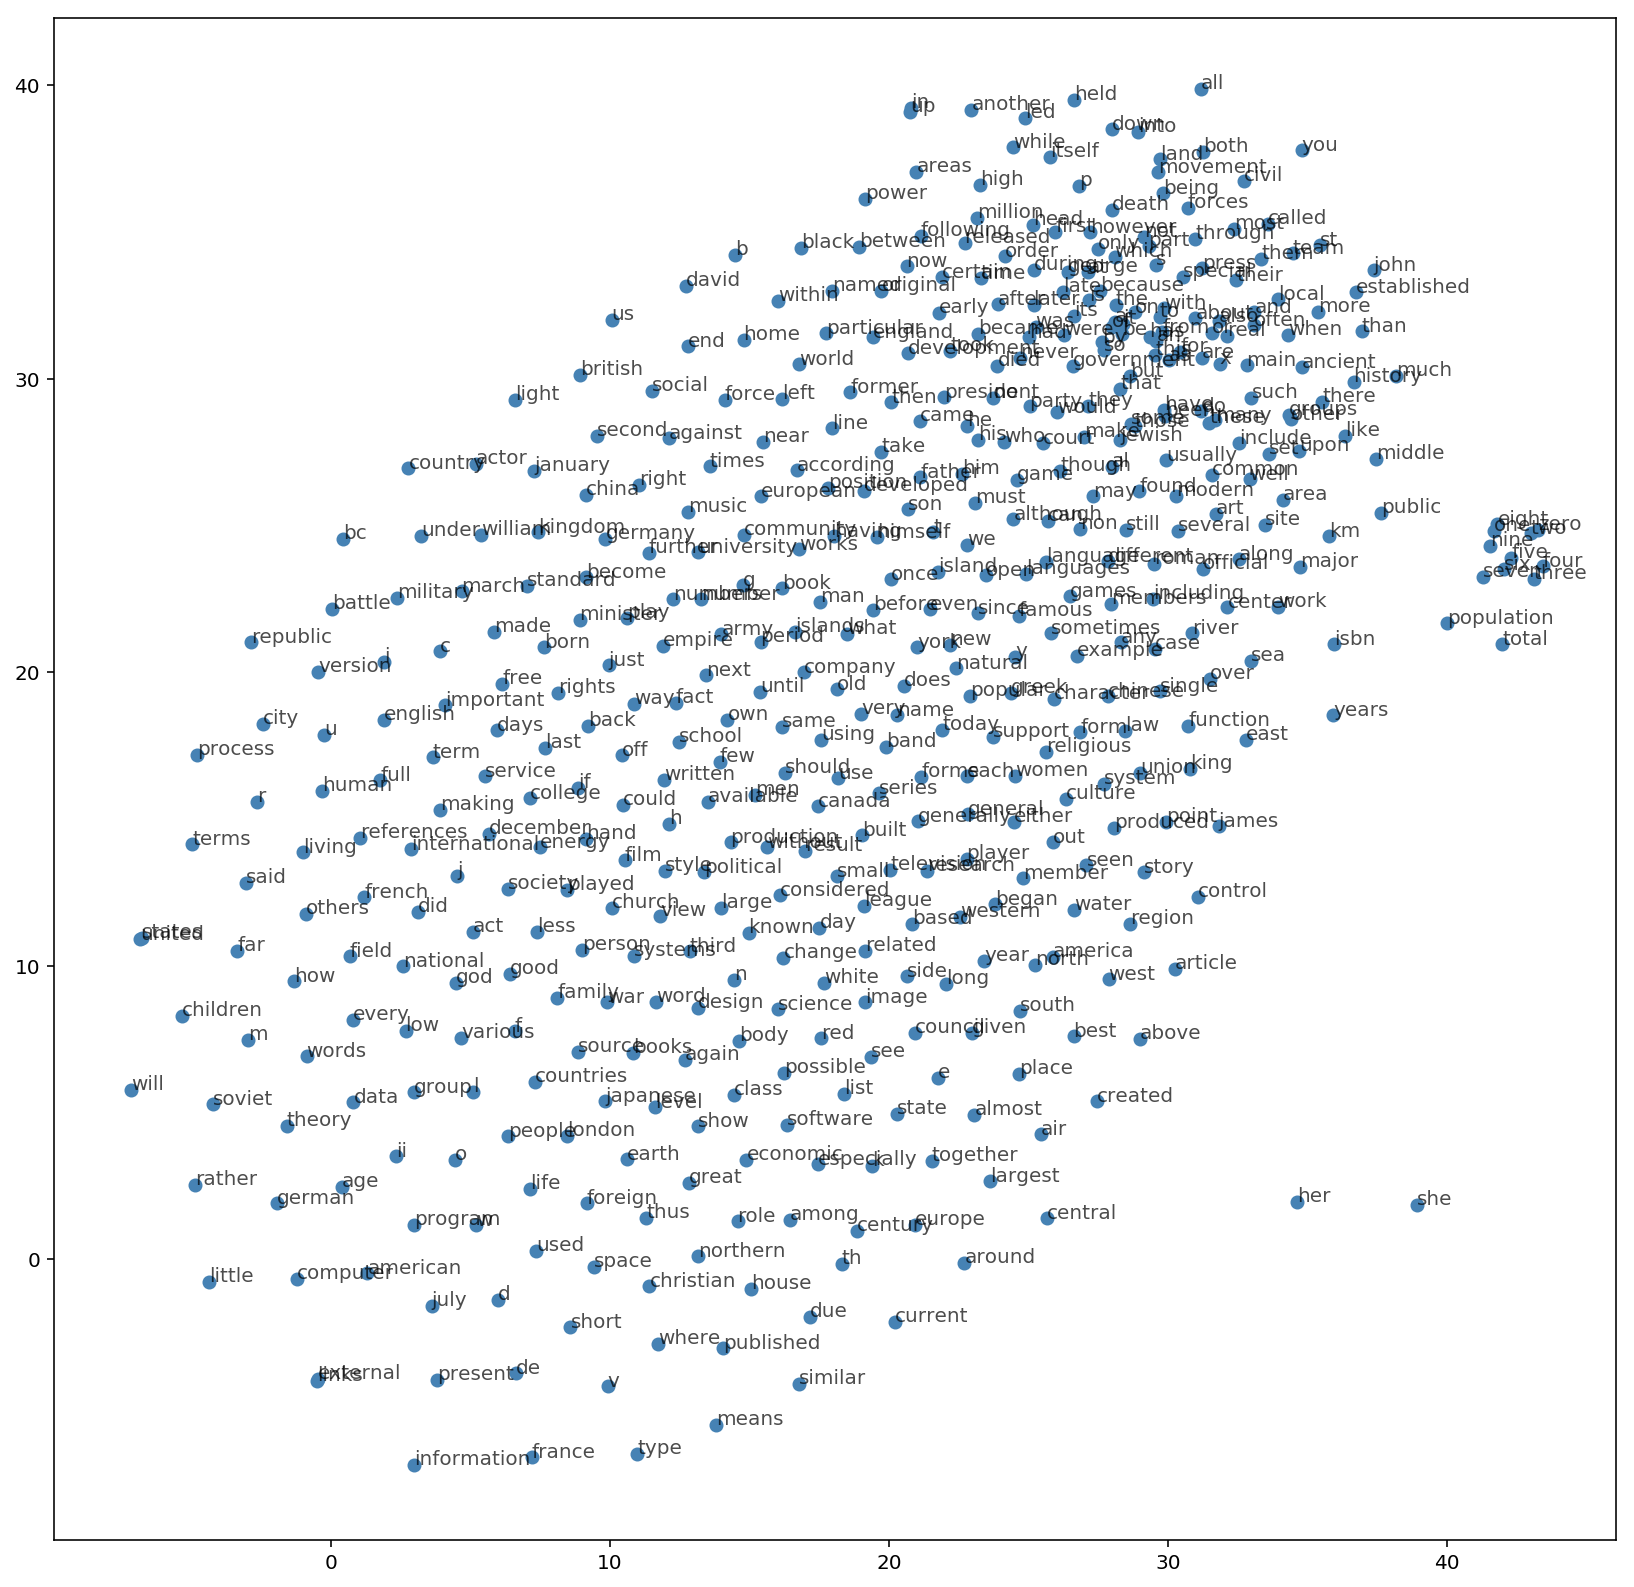

In [51]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)